# 线性回归的从零开始实现

我们将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。
我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

In [3]:
def synthetic_data(w, b, num_examples):  
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

`features` 中的每一行都包含一个二维数据样本，`labels` 中的每一行都包含一维标签值（一个标量）

In [4]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.2955, -1.0879]) 
label: tensor([7.3035])


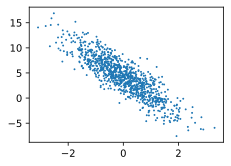

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1);

定义一个`data_iter` 函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.3641,  0.2699],
        [ 0.3296,  0.4542],
        [-1.1132,  1.0895],
        [ 1.2757,  0.6498],
        [ 0.9524,  0.3042],
        [-0.5836,  0.1947],
        [-0.5897,  0.8313],
        [-0.1074,  0.8016],
        [ 0.4579, -1.2450],
        [-1.4151, -0.5781]]) 
 

tensor([[ 4.0051],
        [ 3.3148],
        [-1.7213],
        [ 4.5311],
        [ 5.0792],
        [ 2.3747],
        [ 0.2043],
        [ 1.2614],
        [ 9.3596],
        [ 3.3400]])


定义
初始化模型参数

In [8]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型

In [9]:
def linreg(X, w, b):  
    """线性回归模型。"""
    return torch.matmul(X, w) + b

定义损失函数

In [10]:
def squared_loss(y_hat, y):  
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

定义优化算法

In [11]:
def sgd(params, lr, batch_size):  
    """小批量随机梯度下降。"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练过程

In [13]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.035849
epoch 2, loss 0.000129
epoch 3, loss 0.000052


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [14]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0004, -0.0005], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0002], grad_fn=<RsubBackward1>)
